In [1]:
import pybaseball as pb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.ticker
import os

In [2]:
pb.cache.enable()

In [3]:
start = 2002
end = 2024

In [4]:
batting = pb.batting_stats(start, end, qual = 200)

In [5]:
batting.to_csv('batting.csv')

In [6]:
batting = batting.groupby('IDfg', group_keys=False).filter(lambda x: x.shape[0]>1)

In [7]:
def next_season(player):
    player = player.sort_values('Season')
    player['Next_WAR']=player['WAR'].shift(-1)
    return player

batting = batting.groupby('IDfg', group_keys=False).apply(next_season)

C:\Users\dylan\AppData\Local\Temp\ipykernel_19812\329275703.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  batting = batting.groupby('IDfg', group_keys=False).apply(next_season)


In [8]:
batting[['Name', 'Season','WAR', 'Next_WAR']]

,Name,Season,WAR,Next_WAR
6062,Alfredo Amezaga,2006,1.1,2.0
5438,Alfredo Amezaga,2007,2.0,1.2
5710,Alfredo Amezaga,2008,1.2,NaN
1228,Garret Anderson,2002,3.7,5.1
900,Garret Anderson,2003,5.1,0.8
...,...,...,...,...
1166,Seiya Suzuki,2024,3.5,NaN
5630,Zach Neto,2023,1.1,3.5
3358,Zach Neto,2024,3.5,NaN
2695,Masataka Yoshida,2023,0.7,0.8


In [9]:
null_count = batting.isnull().sum()
complete_cols = list(batting.columns[null_count==0])

In [10]:
batting = batting[complete_cols+['Next_WAR']].copy()

In [11]:
del batting['Dol']
del batting['Age Rng']

In [12]:
batting['team_code']=batting['Team'].astype('category').cat.codes

In [13]:
batting_full = batting.copy()

In [14]:
batting = batting.dropna()

In [15]:
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit

In [16]:
rr=Ridge(alpha = 1)
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(rr, n_features_to_select=20, direction='forward', cv=split, n_jobs=4)

In [17]:
removed_columns = ['Next_WAR', 'Name', 'Team', 'IDfg', 'Season']
selected_columns = batting.columns[~batting.columns.isin(removed_columns)]

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
batting.loc[:,selected_columns] = scaler.fit_transform(batting[selected_columns])

C:\Users\dylan\AppData\Local\Temp\ipykernel_19812\2329648406.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.34615385 0.38461538 0.42307692 ... 0.34615385 0.11538462 0.38461538]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  batting.loc[:,selected_columns] = scaler.fit_transform(batting[selected_columns])
C:\Users\dylan\AppData\Local\Temp\ipykernel_19812\2329648406.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.73504274 0.74358974 0.95726496 ... 0.78632479 0.32478632 0.8034188 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  batting.loc[:,selected_columns] = scaler.fit_transform(batting[selected_columns])
C:\Users\dylan\AppData\Local\Temp\ipykernel_19812\2329648406.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will

In [19]:
sfs.fit(batting[selected_columns], batting['Next_WAR'])

AttributeError: 'bool' object has no attribute 'all'

AttributeError: 'bool' object has no attribute 'all'

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=Ridge(alpha=1), n_features_to_select=20,
                          n_jobs=4)

In [20]:
predictors = list(selected_columns[sfs.get_support()])

In [21]:
predictors

['Age',
 'IBB',
 'SO',
 'SB',
 'BU',
 'OBP',
 'ISO',
 'BABIP',
 'IFH%',
 'Pos',
 'WAR',
 'Spd',
 'PH',
 'CB%',
 'O-Contact%',
 'Pull%',
 'Soft%',
 'LD+%',
 'Oppo%+',
 'Hard%+']

In [22]:
def backtest(data, model, predictors, start = 5, step = 1):
    all_predictions = []
    years = sorted(data['Season'].unique())

    for i in range(start, len(years), step):
        current_year = years[i]
        train = data[data['Season']<current_year]
        test = data[data['Season']==current_year]

        model.fit(train[predictors], train['Next_WAR'])

        preds = model.predict(test[predictors])

        preds = pd.Series(preds, index = test.index)

        combined = pd.concat([test['Next_WAR'], preds], axis=1)
        combined.columns = ['actual', 'prediction']

        all_predictions.append(combined)

    return pd.concat(all_predictions)

In [23]:
predictions = backtest(batting, rr, predictors)

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
from sklearn.metrics import root_mean_squared_error

In [26]:
root_mean_squared_error(predictions['actual'], predictions['prediction'])

1.640986491420713

In [27]:
batting['Next_WAR'].describe()

count    6156.000000
mean        1.788207
std         1.975259
min        -3.100000
25%         0.400000
50%         1.500000
75%         2.900000
max        11.900000
Name: Next_WAR, dtype: float64

In [28]:
def player_history(df):
    df=df.sort_values('Season')
    df['player_season']=range(0,df.shape[0])
    df['war_corr']=list(df[['player_season','WAR']].expanding().corr().loc[(slice(None),'player_season'),'WAR'])
    df['war_corr'].fillna(1, inplace=True)
    df['war_diff']=df['WAR']/df['WAR'].shift(1)
    df['war_diff'].fillna(1,inplace=True)
    df['war_diff'][df['war_diff']==np.inf]=1
    return df



In [29]:
batting = batting.groupby('IDfg', group_keys=False).apply(player_history)

C:\Users\dylan\AppData\Local\Temp\ipykernel_19812\3597674933.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['war_corr'].fillna(1, inplace=True)
C:\Users\dylan\AppData\Local\Temp\ipykernel_19812\3597674933.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [30]:
def group_averages(df):
    return df['WAR']/df['WAR'].mean()


In [31]:
batting['war_season']=batting.groupby('Season', group_keys=False).apply(group_averages)

C:\Users\dylan\AppData\Local\Temp\ipykernel_19812\927760922.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  batting['war_season']=batting.groupby('Season', group_keys=False).apply(group_averages)


In [32]:
new_predictors = predictors+['player_season','war_corr', 'war_season', 'war_diff']

In [33]:
predictions = backtest(batting, rr, new_predictors)

In [34]:
root_mean_squared_error(predictions['actual'], predictions['prediction'])

1.6270342318886708

In [35]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import svm

In [36]:
las = Lasso(alpha=0.1)
en = ElasticNet()
sv = svm.SVR(kernel='linear')


In [37]:
#must remove RAR and L-WAR, predictor matrix is near-singular

print(batting['WAR'].corr(batting['RAR']))
print(batting['WAR'].corr(batting['L-WAR']))

0.9985668909180777
0.9973778788431662


In [38]:
removed_columns = ['Next_WAR', 'Name', 'Team', 'IDfg', 'Season', 'L-WAR', 'RAR']
selected_columns = batting.columns[~batting.columns.isin(removed_columns)]

In [45]:
lasso_sfs = SequentialFeatureSelector(las, n_features_to_select=20, direction='forward', cv=split, n_jobs=4)

lasso_sfs.fit(batting[selected_columns], batting['Next_WAR'])

AttributeError: 'bool' object has no attribute 'all'

AttributeError: 'bool' object has no attribute 'all'

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=Lasso(alpha=0.1), n_features_to_select=20,
                          n_jobs=4)

In [46]:
lasso_predictors = list(selected_columns[lasso_sfs.get_support()])

In [47]:
lasso_predictors

['Age',
 'G',
 'H',
 '1B',
 '2B',
 '3B',
 'BB',
 'IBB',
 'SO',
 'HBP',
 'SF',
 'SH',
 'GDP',
 'SB',
 'CS',
 'AVG',
 'player_season',
 'war_corr',
 'war_diff',
 'war_season']

In [48]:
lasso_predictions = backtest(batting, las, lasso_predictors)

In [49]:
root_mean_squared_error(lasso_predictions['actual'], lasso_predictions['prediction'])

1.7274372941699818

In [52]:
def compute_aic(n, mse, k):
    return n * np.log(mse) + 2 * k

def compute_bic(n, mse, k):
    return n * np.log(mse) + k * np.log(n)

In [92]:
#find the optimal model size for a ridge model.

rr = Ridge(alpha=1)
split = TimeSeriesSplit(n_splits=3)
feature_count = range(3, 31)
mses = []
aics = []
bics = []

for i in feature_count:
    sfs = SequentialFeatureSelector(
        rr, 
        n_features_to_select=i,
        direction='forward',
        cv=split,
        n_jobs=-1
    )
    sfs.fit(batting[selected_columns], batting['Next_WAR'])

    predictors = list(selected_columns[sfs.get_support()])

    predictions = backtest(batting, rr, predictors)

    mse = mean_squared_error(predictions['actual'], predictions['prediction'])
    mses.append(mse)

    aic = compute_aic(batting.shape[0], mse, i)
    aics.append(aic)

    bic = compute_bic(batting.shape[0], mse, i)
    bics.append(bic)



    


In [93]:
best_by_mse = feature_count[np.argmin(mses)]
print(f'The Best Number of Predictors by MSE is {best_by_mse}, with a MSE score of {round(min(mses),3)}')




The Best Number of Predictors by MSE is 30, with a MSE score of 2.623


In [2]:
best_by_aic = feature_count[np.argmin(aics)]
print(f'The Best Number of Predictors by AIC is {best_by_aic}, with a AIC score of {round(min(aics),3)}')

NameError: name 'feature_count' is not defined

In [95]:
best_by_bic = feature_count[np.argmin(bics)]
print(f'The Best Number of Predictors by BIC is {best_by_bic}, with a BIC score of {round(min(bics),3)}')

The Best Number of Predictors by BIC is 15, with a BIC score of 6098.038


In [96]:
import seaborn as sns

In [ ]:
index = [x for x in range(3,31)]


,0
3,2.787833
4,2.756317
5,2.731534
6,2.718081
7,2.704824
8,2.682688
9,2.677936
10,2.668960
11,2.663165
12,2.656105


: 

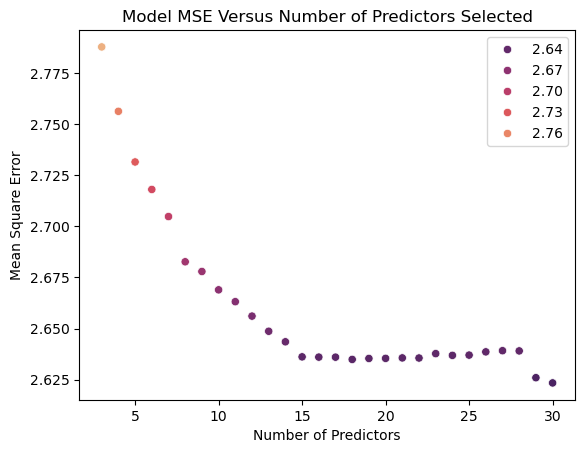

ValueError: If using all scalar values, you must pass an index

In [ ]:
min_x = float(feature_count[np.argmin(mses)])
min_y = min(mses)


sns.scatterplot(
    x=feature_count,
    y=mses,
    hue=mses, 
    palette='flare_r' 
)
plt.title("Model MSE Versus Number of Predictors Selected")
plt.ylabel('Mean Square Error')
plt.xlabel('Number of Predictors')
plt.show()

sns.scatterplot(
    x,
    y=min_y
)



In [1]:
sns.scatterplot(
    x=feature_count,
    y=mses,
    hue=mses, 
    palette='flare_r' 
)
plt.title("Model MSE Versus Number of Predictors Selected")
plt.ylabel('Mean Square Error')
plt.xlabel('Number of Predictors')
plt.show()

NameError: name 'sns' is not defined